# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [12]:
import numpy as np

class Node:
    # 该类为所有其他图节点类的父类
    def __init__(self, inputs=[]):
        #定义每个节点的输入和输出
        self.inputs = inputs
        self.outputs = []
        
        #每个节点都是其输入节点的输出节点
        for n in self.inputs:
            # 把自身加入到输入节点的输出节点列表中
            n.outputs.append(self)

        self.value = None
        
        self.gradients = {}
        # 梯度是dict形式，key是input节点，value是输入节点对这个节点的偏导
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        #前向传播函数 继承该类的其他类会覆写该函数
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):
        #反向传播函数，继承该类的其他类会覆写该函数

        raise NotImplemented
        
class Input(Node):
    # 输入节点，包括神经网络输入节点，权重节点，和偏差节点
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        #定义节点数值
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #计算节点梯度
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            #以下计算该节点的输出节点对该节点的梯度
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        # 把它所有input的value值累加
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    #全连接网络层的计算
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        #前向传播计算 y = w*x + b
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        #反向传播计算
        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            #以下分别计算对inputs， weights, bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        #前向 即为sigmoid函数计算
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        #反向传播计算梯度
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    # 定义平均平方误差
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        #反向计算相应梯度
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [23]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []

In [24]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 183.679
Epoch: 101, Loss: 7.998
Epoch: 201, Loss: 5.202
Epoch: 301, Loss: 3.858
Epoch: 401, Loss: 3.791
Epoch: 501, Loss: 3.808
Epoch: 601, Loss: 3.414
Epoch: 701, Loss: 3.212
Epoch: 801, Loss: 3.340
Epoch: 901, Loss: 3.504
Epoch: 1001, Loss: 2.619
Epoch: 1101, Loss: 3.069
Epoch: 1201, Loss: 3.383
Epoch: 1301, Loss: 2.894
Epoch: 1401, Loss: 2.873
Epoch: 1501, Loss: 3.299
Epoch: 1601, Loss: 2.903
Epoch: 1701, Loss: 2.696
Epoch: 1801, Loss: 3.373
Epoch: 1901, Loss: 2.970
Epoch: 2001, Loss: 3.157
Epoch: 2101, Loss: 3.259
Epoch: 2201, Loss: 3.522
Epoch: 2301, Loss: 2.366
Epoch: 2401, Loss: 2.537
Epoch: 2501, Loss: 2.595
Epoch: 2601, Loss: 3.338
Epoch: 2701, Loss: 2.944
Epoch: 2801, Loss: 2.721
Epoch: 2901, Loss: 2.577
Epoch: 3001, Loss: 2.784
Epoch: 3101, Loss: 2.878
Epoch: 3201, Loss: 3.013
Epoch: 3301, Loss: 3.510
Epoch: 3401, Loss: 2.728
Epoch: 3501, Loss: 3.065
Epoch: 3601, Loss: 3.041
Epoch: 3701, Loss: 2.962
Epoch: 3801, Loss: 3.105
Epoc

In [30]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [32]:
forward(l2,graph)

array([[23.42450975],
       [22.40777964],
       [27.25478659],
       [19.96765148],
       [21.46174182],
       [13.34363569],
       [50.39736562],
       [32.81268678],
       [19.68591933],
       [20.37913184],
       [20.48932325],
       [18.86990291],
       [19.33166824],
       [20.48932325],
       [36.57321351],
       [19.94384745]])

In [34]:
import matplotlib.pyplot as plt

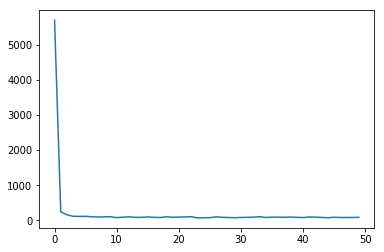

In [35]:
plt.plot(range(len(losses)), losses)

In [36]:
W2.value

array([[ 6.58202748],
       [10.72925089],
       [ 5.16823646],
       [ 7.81252185],
       [13.61672136],
       [ 5.01858109],
       [ 8.49381454],
       [12.17890184],
       [-4.65025291],
       [10.73876586]])

In [38]:
X_ = data['data']
# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [37]:
import keras

C:\Users\myx\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [42]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [43]:
history = model.fit(X_, y_, epochs=500, batch_size=32)

Epoch 1/500
506/506 [==============================] - 0s 552us/step - loss: 142.0431 - mean_squared_error: 142.0431
Epoch 2/500
506/506 [==============================] - 0s 93us/step - loss: 59.4669 - mean_squared_error: 59.4669
Epoch 3/500
506/506 [==============================] - 0s 93us/step - loss: 46.6998 - mean_squared_error: 46.6998
Epoch 4/500
506/506 [==============================] - 0s 91us/step - loss: 38.3405 - mean_squared_error: 38.3405
Epoch 5/500
506/506 [==============================] - 0s 85us/step - loss: 31.3586 - mean_squared_error: 31.3586
Epoch 6/500
506/506 [==============================] - 0s 89us/step - loss: 26.7903 - mean_squared_error: 26.7903
Epoch 7/500
506/506 [==============================] - 0s 87us/step - loss: 24.9205 - mean_squared_error: 24.9205
Epoch 8/500
506/506 [==============================] - 0s 84us/step - loss: 23.5046 - mean_squared_error: 23.5046
Epoch 9/500
506/506 [==============================] - 0s 87us/step - loss: 21.6917 -

506/506 [==============================] - 0s 165us/step - loss: 10.6758 - mean_squared_error: 10.6758
Epoch 73/500
506/506 [==============================] - 0s 158us/step - loss: 10.5160 - mean_squared_error: 10.5160
Epoch 74/500
506/506 [==============================] - 0s 112us/step - loss: 10.5997 - mean_squared_error: 10.5997
Epoch 75/500
506/506 [==============================] - 0s 79us/step - loss: 10.7965 - mean_squared_error: 10.7965
Epoch 76/500
506/506 [==============================] - 0s 83us/step - loss: 10.0754 - mean_squared_error: 10.0754
Epoch 77/500
506/506 [==============================] - 0s 201us/step - loss: 10.4741 - mean_squared_error: 10.4741
Epoch 78/500
506/506 [==============================] - 0s 118us/step - loss: 10.6879 - mean_squared_error: 10.6879
Epoch 79/500
506/506 [==============================] - 0s 154us/step - loss: 10.2030 - mean_squared_error: 10.2030
Epoch 80/500
506/506 [==============================] - 0s 89us/step - loss: 10.2626 - 

506/506 [==============================] - 0s 82us/step - loss: 6.8299 - mean_squared_error: 6.8299
Epoch 144/500
506/506 [==============================] - 0s 77us/step - loss: 6.9381 - mean_squared_error: 6.9381
Epoch 145/500
506/506 [==============================] - 0s 83us/step - loss: 7.0762 - mean_squared_error: 7.0762
Epoch 146/500
506/506 [==============================] - 0s 83us/step - loss: 6.8471 - mean_squared_error: 6.8471
Epoch 147/500
506/506 [==============================] - 0s 83us/step - loss: 6.6623 - mean_squared_error: 6.6623
Epoch 148/500
506/506 [==============================] - 0s 182us/step - loss: 6.8068 - mean_squared_error: 6.8068
Epoch 149/500
506/506 [==============================] - 0s 132us/step - loss: 6.9022 - mean_squared_error: 6.9022
Epoch 150/500
506/506 [==============================] - 0s 93us/step - loss: 6.5804 - mean_squared_error: 6.5804
Epoch 151/500
506/506 [==============================] - 0s 81us/step - loss: 6.7310 - mean_squared_

506/506 [==============================] - 0s 81us/step - loss: 5.2004 - mean_squared_error: 5.2004
Epoch 215/500
506/506 [==============================] - 0s 80us/step - loss: 4.8874 - mean_squared_error: 4.8874
Epoch 216/500
506/506 [==============================] - 0s 81us/step - loss: 4.9756 - mean_squared_error: 4.9756
Epoch 217/500
506/506 [==============================] - 0s 79us/step - loss: 4.8848 - mean_squared_error: 4.8848
Epoch 218/500
506/506 [==============================] - 0s 84us/step - loss: 4.8513 - mean_squared_error: 4.8513
Epoch 219/500
506/506 [==============================] - 0s 83us/step - loss: 4.9859 - mean_squared_error: 4.9859
Epoch 220/500
506/506 [==============================] - 0s 83us/step - loss: 5.0443 - mean_squared_error: 5.0443
Epoch 221/500
506/506 [==============================] - 0s 87us/step - loss: 4.8756 - mean_squared_error: 4.8756
Epoch 222/500
506/506 [==============================] - 0s 89us/step - loss: 4.9924 - mean_squared_er

506/506 [==============================] - 0s 83us/step - loss: 4.0792 - mean_squared_error: 4.0792
Epoch 286/500
506/506 [==============================] - 0s 75us/step - loss: 4.4224 - mean_squared_error: 4.4224
Epoch 287/500
506/506 [==============================] - 0s 82us/step - loss: 4.1507 - mean_squared_error: 4.1507
Epoch 288/500
506/506 [==============================] - 0s 179us/step - loss: 4.1635 - mean_squared_error: 4.1635
Epoch 289/500
506/506 [==============================] - 0s 158us/step - loss: 4.4838 - mean_squared_error: 4.4838
Epoch 290/500
506/506 [==============================] - 0s 97us/step - loss: 4.1479 - mean_squared_error: 4.1479
Epoch 291/500
506/506 [==============================] - 0s 89us/step - loss: 4.0680 - mean_squared_error: 4.0680
Epoch 292/500
506/506 [==============================] - 0s 94us/step - loss: 3.9875 - mean_squared_error: 3.9875
Epoch 293/500
506/506 [==============================] - 0s 83us/step - loss: 3.9833 - mean_squared_

506/506 [==============================] - 0s 79us/step - loss: 3.5181 - mean_squared_error: 3.5181
Epoch 357/500
506/506 [==============================] - 0s 85us/step - loss: 3.5744 - mean_squared_error: 3.5744
Epoch 358/500
506/506 [==============================] - 0s 89us/step - loss: 3.6162 - mean_squared_error: 3.6162
Epoch 359/500
506/506 [==============================] - 0s 95us/step - loss: 3.5114 - mean_squared_error: 3.5114
Epoch 360/500
506/506 [==============================] - 0s 93us/step - loss: 3.4297 - mean_squared_error: 3.4297
Epoch 361/500
506/506 [==============================] - 0s 87us/step - loss: 3.4897 - mean_squared_error: 3.4897
Epoch 362/500
506/506 [==============================] - 0s 85us/step - loss: 3.5273 - mean_squared_error: 3.5273
Epoch 363/500
506/506 [==============================] - 0s 171us/step - loss: 3.5205 - mean_squared_error: 3.5205
Epoch 364/500
506/506 [==============================] - 0s 184us/step - loss: 3.3410 - mean_squared_

506/506 [==============================] - 0s 95us/step - loss: 3.0419 - mean_squared_error: 3.0419
Epoch 428/500
506/506 [==============================] - 0s 97us/step - loss: 2.9446 - mean_squared_error: 2.9446
Epoch 429/500
506/506 [==============================] - 0s 87us/step - loss: 2.9729 - mean_squared_error: 2.9729
Epoch 430/500
506/506 [==============================] - 0s 73us/step - loss: 3.0044 - mean_squared_error: 3.0044
Epoch 431/500
506/506 [==============================] - 0s 83us/step - loss: 2.9969 - mean_squared_error: 2.9969
Epoch 432/500
506/506 [==============================] - 0s 86us/step - loss: 3.0738 - mean_squared_error: 3.0738
Epoch 433/500
506/506 [==============================] - 0s 82us/step - loss: 3.1559 - mean_squared_error: 3.1559
Epoch 434/500
506/506 [==============================] - 0s 91us/step - loss: 3.0636 - mean_squared_error: 3.0636
Epoch 435/500
506/506 [==============================] - 0s 75us/step - loss: 2.8896 - mean_squared_er

506/506 [==============================] - 0s 106us/step - loss: 2.6202 - mean_squared_error: 2.6202
Epoch 499/500
506/506 [==============================] - 0s 105us/step - loss: 2.7448 - mean_squared_error: 2.7448
Epoch 500/500
506/506 [==============================] - 0s 133us/step - loss: 2.5275 - mean_squared_error: 2.5275


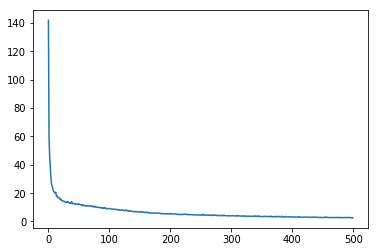

In [44]:
plt.plot(history.history['loss'])

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

一个神经元是一个线性函数 y=Wx+b, 后面可能还跟着一个激活函数。

####  2. Why we use non-linear activation funcitons in neural networks?

1.如果没有引入非线性激活函数，全是线性函数，那么无论多少层神经网络，都能化简为一层神经网络。  
2.世界是复杂的，不是纯线性函数就可以拟合的，比如引入非线性函数，才可以更好地拟合复杂的世界。

#### 3. What is the 'Logistic Loss' ?

Logitstic Loss是Cross Entropy Loss在二分类场景中的特例。  
loss = -(ylog(y^) + (1-y)log(1-y^))

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

推荐使用sigmoid激活函数。sigmoid的取值范围是[0,1]，比较符合二分类场景。  
relu范围是[0, +∞],leaky relu也是从0附近到+∞。  
tanh范围是[-1,1].  
相比之下，sigmoid最适合二分类。

#### 5. Why we don't use zero initialization for all parameters ?

神经网络具有对称性。如果初始化全0，那么在这样的对称性结构下，反向传播/梯度下降计算后，相同层的多个神经元参数会相同，模型难以收敛。

#### 6. Can you implement the softmax function using python ? 

In [279]:
import numpy as np

def softmax(y_input):
    # 行为种类，每列为一个样本标签
    temp = np.exp(y_input)
    return temp/np.sum(temp, axis=0)

In [281]:
softmax([[1,2,3,4], [5,5,5,5]])

array([[0.01798621, 0.04742587, 0.11920292, 0.26894142],
       [0.98201379, 0.95257413, 0.88079708, 0.73105858]])

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [45]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [46]:
# Loading the data 
digits = datasets.load_digits()

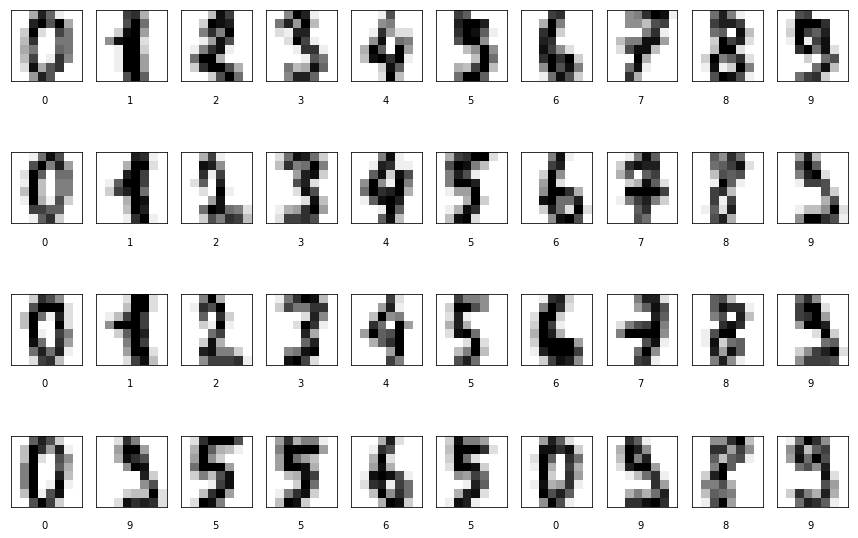

In [102]:
# Vilizating the data
plt.figure(figsize=(15,10))
for i in range(1,41):
    plt.subplot(4,10,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [103]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [104]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [105]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](./networks.png)

## 直接用sklearn内部的逻辑斯蒂回归函数计算

In [59]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
y_pre = lr.predict(X_test)
y_pre

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,

In [63]:
# 计算预测的正确率
np.mean(y_pre == y_test)

0.8711111111111111

In [64]:
# 用自带的函数计算预测正确率
lr.score(X_test, y_test)

0.8711111111111111

## 使用sklearn的神经网络模型计算

In [66]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(10, 2), random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [68]:
# 计算正确率
clf.score(X_test, y_test)

0.9644444444444444

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [297]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1 / (1 + np.exp(-z))
    return s

In [74]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))
print("sigmoid([[0,2], [0,2]]) = " + str(sigmoid(np.array([[0,2], [0,2]]))))

sigmoid([0,2]) = [0.5        0.88079708]
sigmoid([[0,2], [0,2]]) = [[0.5        0.88079708]
 [0.5        0.88079708]]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [298]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.random((dim,1))
    b = 0

    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [299]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    temp = Y * np.log(A) + (1 - Y) * np.log(1 - A)

    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A), axis=1)
    
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y, axis=1)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [300]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    batch_size = 50
    for j in range(num_iterations):
        costs = []
        for i in range(0, X.shape[1], batch_size):
            X_ = X[:,i:i+batch_size]
            Y_ = Y[:,i:i+batch_size]

            grads, cost = propagate(w,b,X_,Y_)

            dw = grads['dw']
            db = grads['db']

            w -= learning_rate * dw
            b -= learning_rate * db

            costs.append(cost)
        
        cost = sum(costs)/len(costs)
        if print_cost and j % 100 == 0:
            print ("Cost after iteration %i: %f" %(j, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
     
    return params, grads, cost

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [324]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0,i] = 0 if A[0,i] <= 0.5 else 1
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [302]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
#     # X标准化处理
#     X_train /= X_train.max()
#     X_test /= X_train.max()
#     # XY参数格式调整
#     X_train = X_train.T
#     Y_train = np.expand_dims(Y_train, axis=0)
#     X_test = X_test.T
#     Y_test = np.expand_dims(Y_test, axis=0)
    
    # 参数初始化
    w, b = initialize_parameters(X_train.shape[0])
    
    # 训练模型
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
            
    # 训练集精度
    Y_train_ = predict(w, b, X_train)
    traing_accuracy = np.mean(Y_train_ == Y_train)
           
    # 测试集
    Y_pre = predict(w, b, X_test)
    test_accuracy = np.mean(Y_pre == Y_test)
    
    d = {"w":w,
         "b":b,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    
    return d

In [303]:
# 获取数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)
y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

# 数据预处理
# X标准化处理
X_train /= X_train.max()
X_test /= X_train.max()
# XY参数格式调整
X_train = X_train.T
y_train = np.expand_dims(y_train, axis=0)
X_test = X_test.T
y_test = np.expand_dims(y_test, axis=0)

In [304]:
d = model(X_train, y_train, X_test, y_test, 5000, 1e-1, True)
print(d)

Cost after iteration 0: 2.172324
Cost after iteration 100: 0.275033
Cost after iteration 200: 0.256566
Cost after iteration 300: 0.250484
Cost after iteration 400: 0.247739
Cost after iteration 500: 0.246269
Cost after iteration 600: 0.245389
Cost after iteration 700: 0.244817
Cost after iteration 800: 0.244422
Cost after iteration 900: 0.244134
Cost after iteration 1000: 0.243916
Cost after iteration 1100: 0.243745
Cost after iteration 1200: 0.243605
Cost after iteration 1300: 0.243490
Cost after iteration 1400: 0.243391
Cost after iteration 1500: 0.243304
Cost after iteration 1600: 0.243228
Cost after iteration 1700: 0.243159
Cost after iteration 1800: 0.243096
Cost after iteration 1900: 0.243039
Cost after iteration 2000: 0.242985
Cost after iteration 2100: 0.242935
Cost after iteration 2200: 0.242887
Cost after iteration 2300: 0.242842
Cost after iteration 2400: 0.242800
Cost after iteration 2500: 0.242759
Cost after iteration 2600: 0.242719
Cost after iteration 2700: 0.242682
Cost

In [305]:
y_pre = predict(d['w'], d['b'], X_test)
y_pre

array([[1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

学习率越大，学习进度越快。即同样的训练轮次，学习率大的loss值小。

0.0005
0.001
0.0015
0.002
0.0025
0.003
0.0035
0.004
0.0045000000000000005
0.005000000000000001
0.0055
0.006
0.006500000000000001
0.007000000000000001
0.0075
0.008
0.0085
0.009000000000000001
0.009500000000000001
0.01


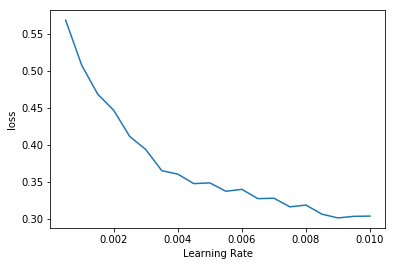

In [306]:
lrs = np.linspace(5e-4, 1e-2, 20, endpoint=True)
costs = []
for i in lrs:
    print(i)
    d = model(X_train, y_train, X_test, y_test, 500, i, False)
    costs.append(d['cost'])
plt.plot(lrs, costs)
plt.xlabel('Learning Rate')
plt.ylabel('loss')
plt.show()

##### 4.2 Observe the effect of iteration_num on the test accuracy.

训练轮次越多，正确率越高。
曲线图中产生的抖动猜测是w参数随机初始化的影响。

200
400
600
800
1000
1200
1400
1600
1800
2000


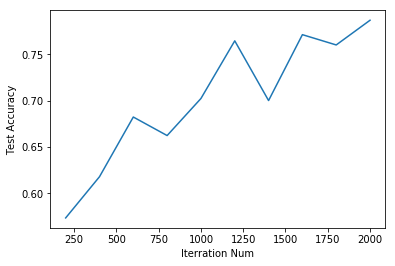

In [309]:
iters = np.linspace(200, 2000, 10, endpoint=True).astype(np.int)
accs = []
for i in iters:
    print(i)
    d = model(X_train, y_train, X_test, y_test, i, 1e-3, False)
    accs.append(d['test_accuracy'])
plt.plot(iters, accs)
plt.xlabel('Iterration Num')
plt.ylabel('Test Accuracy')
plt.show()

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

In [328]:
def initialize_parameters_2(dim1, dim2):

    w = np.random.random((dim1,dim2))
    b = np.zeros((dim2, 1))

    return w,b

def softmax(z):
    temp = np.exp(z)
    return temp/np.sum(temp, axis=0)

# 重写反向传播函数
def propagate_2(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    A = softmax(np.dot(w.T, X) + b)
    temp = Y * np.log(A) + (1 - Y) * np.log(1 - A)

    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y, axis=(0,1))
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

def optimize_2(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    batch_size = 50
    for j in range(num_iterations):
        costs = []
        for i in range(0, X.shape[1], batch_size):
            X_ = X[:,i:i+batch_size]
            Y_ = Y[:,i:i+batch_size]

            grads, cost = propagate_2(w,b,X_,Y_)

            dw = grads['dw']
            db = grads['db']

            w -= learning_rate * dw
            b -= learning_rate * db

            costs.append(cost)
        
        cost = sum(costs)/len(costs)
        if print_cost and j % 100 == 0:
            print ("Cost after iteration %i: %f" %(j, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
     
    return params, grads, cost

def predict_2(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
#     w = w.reshape(X.shape[0],1)
    
    A = softmax(np.dot(w.T, X) + b)
    
    Y_prediction[0] = A.argmax(axis=0)
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

def model_2(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    
    # 参数初始化
    w, b = initialize_parameters_2(X_train.shape[0], Y_train.shape[0])
    
    # 训练模型
    params, grads, costs = optimize_2(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
            
    # 训练集精度
    Y_train_ = predict_2(w, b, X_train)
    traing_accuracy = np.mean(Y_train_ == np.expand_dims(Y_train.argmax(axis=0), axis=0))
           
    # 测试集
    Y_pre = predict_2(w, b, X_test)
    test_accuracy = np.mean(Y_pre == np.expand_dims(Y_test.argmax(axis=0), axis=0))
    
    d = {"w":w,
         "b":b,
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":costs}
    
    return d

In [311]:
# 获取数据
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

# 数据预处理
# X标准化处理
X_train /= X_train.max()
X_test /= X_train.max()
# XY参数格式调整
X_train = X_train.T
y_train = np.eye(10)[y_train].T
X_test = X_test.T
y_test = np.eye(10)[y_test].T

In [331]:
d = model_2(X_train, y_train, X_test, y_test, 5000, 1e-2, True)
print(d)

Cost after iteration 0: 3.729599
Cost after iteration 100: 1.093362
Cost after iteration 200: 0.713761
Cost after iteration 300: 0.562693
Cost after iteration 400: 0.478560
Cost after iteration 500: 0.423736
Cost after iteration 600: 0.384599
Cost after iteration 700: 0.354932
Cost after iteration 800: 0.331463
Cost after iteration 900: 0.312299
Cost after iteration 1000: 0.296262
Cost after iteration 1100: 0.282577
Cost after iteration 1200: 0.270713
Cost after iteration 1300: 0.260292
Cost after iteration 1400: 0.251038
Cost after iteration 1500: 0.242743
Cost after iteration 1600: 0.235247
Cost after iteration 1700: 0.228426
Cost after iteration 1800: 0.222182
Cost after iteration 1900: 0.216434
Cost after iteration 2000: 0.211117
Cost after iteration 2100: 0.206178
Cost after iteration 2200: 0.201572
Cost after iteration 2300: 0.197262
Cost after iteration 2400: 0.193215
Cost after iteration 2500: 0.189405
Cost after iteration 2600: 0.185808
Cost after iteration 2700: 0.182403
Cost

In [275]:
# one-hot编码 
a = np.asarray([0,1,2,1,0])
b = np.eye(3)[a]
b

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

# Congratulations ! You have completed assigment 4. 